### CREATE DAILY INPUT FOR THE SVR MODEL

In [2]:
import sys, importlib
importlib.reload(sys.modules['create_daily_csv'])

KeyError: 'create_daily_csv'

In [1]:
from create_daily_csv import readsnow_in_shp_db,xarray2df,check_data_gap,readnetcdf_in_shp_db,get_discharge_from_DB
from create_daily_csv import spatial_stats_daily_input
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plot
import xarray as xr
import datetime


In [2]:
##### ADO SELECTED GAUGING STATIONS #####

### LARGE ALPINE RIVERS ###

STAT_CODE = 'ADO_DSC_ITC1_0020' # CASALE MONFERRATO PO
STAT_CODE = 'ADO_DSC_ITC1_0037' #PO SANT'ANTONIO

STAT_CODE = 'ADO_DSC_FRK2_0042'  #rhone viviers or valens? maybe better viviers
STAT_CODE = 'ADO_DSC_FRK2_0040' #RHONE VALENCE

STAT_CODE = 'ADO_DSC_AT12_0280'  #donau kienstock

STAT_CODE = 'ADO_DSC_CH03_0075'  #rheine basel

STAT_CODE = 'ADO_DSC_ITH2_0035'  #adige vo destro
STAT_CODE = 'ADO_DSC_ITH1_0012' #adige_bronzolo

### ADO CASE STUDIES ###

STAT_CODE = 'ADO_DSC_ITC1_0072' # orco_SAN BENIGNO
#STAT_CODE = 'ADO_DSC_ITC1_0060' # orco_basin -> PONT SOANA

STAT_CODE = 'ADO_DSC_CH04_0011'  #THURGAU_ANDELFINGEN (ALL THE REGION, BUT OUTSIDE THE ADMINISTRATIVE LIMIT)
STAT_CODE = 'ADO_DSC_CH05_0201' #THURGAU Halden (MUCH SMALLER)

STAT_CODE = 'ADO_DSC_CH07_0006' #ticino bellinzona (larger)
STAT_CODE = 'ADO_DSC_CH07_0147' #ticino pollegio campagna (solo da 86)
STAT_CODE = 'ADO_DSC_CH07_0100' #locarno soldurno.(solo da 86+ bilanci tornano poco)

STAT_CODE = 'ADO_DSC_AT31_0254' #upper-austria traun-wels
STAT_CODE = 'ADO_DSC_AT31_0206' #UA traun-lambach

STAT_CODE = 'ADO_DSC_FRK2_0041'  #DROME SAILLANS

STAT_CODE = 'ADO_DSC_SI03_0148' #DRAVINJA VIDEM (SLIGHTLY WRONG CATCHMENT AREA.)(ONLY PART OF THE STUDY AREA)(ONLY FROM 2001)
#STAT_CODE = 'ADO_DSC_SI03_0117' #DRAVA PTUJ --NODATA
STAT_CODE = 'ADO_DSC_SI03_0033' #DRAVA DRAVOGRAD 

In [10]:
LIST = ['ADO_DSC_ITC1_0020','ADO_DSC_ITC1_0037','ADO_DSC_FRK2_0042',
        'ADO_DSC_AT12_0280','ADO_DSC_CH03_0075', 'ADO_DSC_ITH2_0035',
        'ADO_DSC_ITC1_0072','ADO_DSC_CH04_0011','ADO_DSC_CH07_0006',
        'ADO_DSC_CH07_0147','ADO_DSC_AT31_0254','ADO_DSC_FRK2_0041',
        'ADO_DSC_SI03_0148','ADO_DSC_SI03_0033','ADO_DSC_ITH1_0012',
        'ADO_DSC_CH05_0201','ADO_DSC_CH07_0100','ADO_DSC_AT31_0206']

In [3]:
#recompute glacier basins
LIST = ['ADO_DSC_ITC1_0020','ADO_DSC_ITC1_0037','ADO_DSC_CH03_0075', 
        'ADO_DSC_AT12_0280','ADO_DSC_ITH2_0035','ADO_DSC_ITH1_0012',
        'ADO_DSC_AT12_0277','ADO_DSC_AT12_0280','ADO_DSC_SI03_0033']


LIST = ['ADO_DSC_ITH5_0006']
        
        
        

In [4]:
era5_fileName_t=  'Z:\ADO\ZAMG\downscaled_archive\\2m_temperature-19790101_20201231-eusalp-era5_qm.nc'
era5_fileName_e = 'Z:\ADO\ZAMG\downscaled_archive\\potential_evapotranspiration-19790101_20201231-eusalp-qm_era5.nc'
era5_fileName_p = 'Z:\ADO\ZAMG\downscaled_archive\\total_precipitation-19790101_20201231-eusalp-qm_era5.nc'
era5_foldName_s = 'Z:\ADO\ZAMG\SNOWGRID\\'
# mask file needed to exclude pixels on the glaciers.
mask_file=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\era5\SNOWGRID\\snowgrid_masks.nc'

In [6]:
for STAT_CODE in LIST:
    
    # GET RUNOFF FROM DB:
    discharge=get_discharge_from_DB(STAT_CODE)
    discharge = discharge.rename(columns={'discharge_m3_s': 'Q'})
    
    # reduce the size already
    discharge = discharge[discharge.index > (np.datetime64('1979-12-31'))]  

    
    ### ERA5 temperature

    #CLIP TO THE SHAPEFILE
    t2m = readnetcdf_in_shp_db(era5_fileName_t,STAT_CODE ,plot=False,res=5500)['t2m']
    t2m = xarray2df(t2m.resample(time='1d').sum(skipna=False), 'T','t2m')

    ### ERA5 total precipitation
    
    #CLIP TO THE SHAPEFILE
    tp = readnetcdf_in_shp_db(era5_fileName_p,STAT_CODE ,plot=False,res=5500)['tp']
    tp = xarray2df(tp.resample(time='1d').sum(skipna=False), 'P','tp')


    ### ERA5 evapotranspiration

    #CLIP TO THE SHAPEFILE
    pet = readnetcdf_in_shp_db(era5_fileName_e,STAT_CODE ,plot=False,res=5500)['pet']
    pet = xarray2df(pet.resample(time='1d').sum(skipna=False), 'E','pet')

  
    ### ERA5 SNOW VARIABLES

    #CLIP TO THE SHAPEFILE    
    s = readsnow_in_shp_db(era5_foldName_s, mask_file ,STAT_CODE ,plot=False,res=5500)['swe_tot']
    s = xarray2df(s.resample(time='1d').sum(skipna=False), 'S','swe_tot')    

    # ADD A YEAR OF NO DATA BEFORE THE 1ST COMMON DATE (BTW ERA5 AND DISCHARGE DATA)
    first_date=(max(np.datetime64("1980-01-01"),discharge.index[0]))
    idx=pd.date_range(first_date-np.timedelta64(366,'D'),first_date-np.timedelta64(1,'D'))
    a=pd.DataFrame(np.repeat(np.nan,366),index=idx,columns=['Q'])
    discharge=pd.concat((a,discharge),axis=0)

    
    #CONCATENATE THE VARIABLES
    daily_input = pd.concat([discharge, t2m, tp, pet, s], axis=1, join='inner')
    
    daily_input_stat = spatial_stats_daily_input(daily_input)

    #DEFINE THE PATH AND FILENAME
    catchment_name = STAT_CODE + '.csv'
    path=r'C:\Users\mmazzolini\OneDrive - Scientific Network South Tyrol\Documents\conda\daily_input\\'+catchment_name
    
    
    #save into a csv file.
    # if file does not exist write
    if not os.path.isfile(path):
       daily_input_stat.to_csv(path)
    else: # else print the problem
       print('file already exists'+STAT_CODE)

<AxesSubplot:>

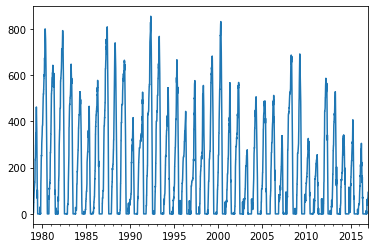

In [16]:
daily_input.Sx5y0.plot.line()

Input:
- the measured runoff at the gauging station,
- the catchment area of the gauging station,
- the ERA5 datasets for Potential Evapotranspiration, Temperature and Precipitation.

Output:
    - a .csv file is saved in conda/daily_input folder.

import sys, importlib
importlib.reload(sys.modules['sf_runoff'])